In [1]:
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm
from matplotlib.pyplot import cm

In [22]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

In [23]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [24]:
def double_gaussian(x, mu, sig, A, mu2, sig2, A2):
    return gaussian(x, mu, sig, A)+gaussian(x, mu2, sig2, A2)

In [31]:
array = pd.read_csv('../data/test_array.csv') #spaces in csv file will make df object type and not float64
array = array.loc[array['Species'].str.endswith('S I')]

In [32]:
guess = array.to_numpy()
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

In [33]:
C = np.delete(guess, 1, 1)
C = C.tolist()

In [172]:
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2
errfunc2 = lambda p, x, y: (double_gaussian(x, *p) - y)**2
x = 17 #28 is the biggest problem file, show 15 to see overlap in fit and data
guess1 = C[x]
#guess1 = [1256.093, 0.23, 7.89*10**-17] #manually input guess where sigma is smaller
guess2 = C[x],C[x+1]
guess1, guess2

([1262.86, 0.23, 1.59e-15],
 ([1262.86, 0.23, 1.59e-15], [1269.209, 0.23, 2.92e-16]))

In [173]:
optim1, success = optimize.leastsq(errfunc1, guess1, args=(wl, flux))
optim2, success = optimize.leastsq(errfunc2, guess2, args=(wl, flux))

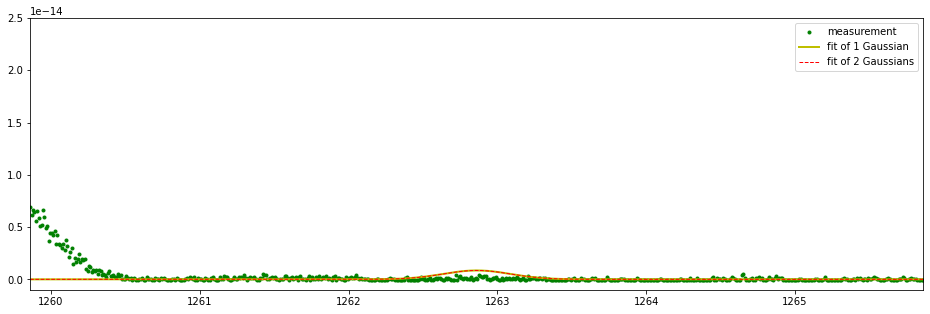

In [161]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux,'g.', label='measurement')
plt.plot(wl, gaussian(wl, *optim1),
    lw=2, c='y', label='fit of 1 Gaussian')
plt.plot(wl, double_gaussian(wl, *optim2),
    lw=1, c='r', ls='--', label='fit of 2 Gaussians')
plt.ylim(-0.01*10**-13,0.25*10**-13)
plt.xlim(guess1[0]-3,guess1[0]+3)
plt.legend(loc='best')

In [116]:
def fit_whole_spectra(array):
    params = np.zeros((len(C),3))
    for index in tqdm(range(0, len(array))):
        guess1 = C[index]
        optim1, success = optimize.leastsq(errfunc1, guess1, args=(wl, flux))
        params[index] = optim1
        #params = np.append(params,optim1,axis=0)
    return params

In [38]:
params = fit_whole_spectra(C)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:05<00:00,  9.44it/s]


In [39]:
mu = params[:,0]
sigma = params[:,1]
amp = params[:,2]

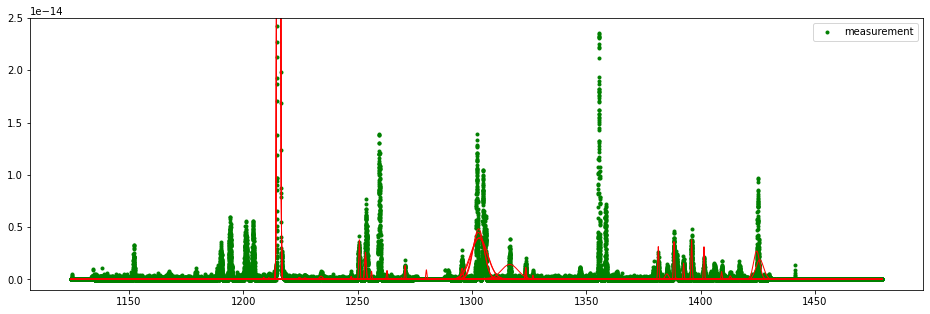

In [40]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux,'g.', label='measurement')
for index in range(0,len(params)):
    plt.plot(wl, gaussian(wl, mu[index], sigma[index], amp[index]), lw=1, c='r')
#plt.plot(wl, gaussian(wl, mu[15], sigma[15], amp[15]), lw=2, c='y', label='fit of 1 Gaussian')
plt.ylim(-0.01*10**-13,0.25*10**-13)
#plt.xlim(1280,1320)
plt.legend(loc='best')

In [182]:
import scipy.optimize as sop
import numpy as np
def ftest(x):
    x,y,z = x
    data = np.array([3.65,2.41,1.59])# arbitrary & just for testing
    model = np.array([x**2,y**2,z**2])# arbitrary & just for testing
    residuals = data - model 
    return residuals
def ftest2(x):
    return sum(ftest(x)**2)# to ask fmin to minimize the chi2 but it can be anything
p0 = np.array([1,2,3])# arbitrary & just for testing
opt = sop.fmin(ftest2, p0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 131


In [185]:
opt = optimize.least_squares(errfunc1, guess1, args=(wl, flux))

In [188]:
opt['x']

array([1.26286e+03, 2.30000e-01, 1.59000e-15])